<a href="https://colab.research.google.com/github/fzanart/Cookbook/blob/main/Huggingface/Github_domains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%%capture
!pip install datasets
!pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
%%capture
!wget https://github.com/fzanart/GHDomains/raw/main/expanded_frame_final.csv.zip

In [5]:
#%%capture
!unzip /content/expanded_frame_final.csv.zip

Archive:  /content/expanded_frame_final.csv.zip
  inflating: expanded_frame_final.csv  
  inflating: __MACOSX/._expanded_frame_final.csv  


In [29]:
import pandas as pd
import numpy as np
from datasets import Dataset,DatasetDict, Value, ClassLabel, Features
from transformers import AutoModelForSequenceClassification,AutoTokenizer, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix


In [3]:
df = pd. read_csv('/content/expanded_frame_final.csv', usecols=['Description', 'Domain']) #TODO: find and filter columns data #'Languages'
df = df[~df['Description'].isnull()].reset_index(drop=True)
df = df.rename(columns={"Description": "text", "Domain": "label"})
df['text'] = df['text'].apply(str)
features = Features({"text": Value("string"), "label": ClassLabel(num_classes=6, names=['Application software', 'Documentation', 'Non-web libraries and frameworks', 'Software tools','System software', 'Web libraries and frameworks'])})
ds = Dataset.from_pandas(df, features=features)
ds_train_test = ds.train_test_split(test_size=0.2, stratify_by_column="label")
ds_test_valid = ds_train_test['test'].train_test_split(test_size=0.5, stratify_by_column="label")
ds = DatasetDict({'train':ds_train_test['train'], 'test':ds_test_valid['train'], 'valid':ds_test_valid['test']})
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3941
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 493
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 493
    })
})

In [4]:
ds.set_format(type='pandas')
df = ds['train'][:]

def label_int2str(row):
  return ds['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,"A solid, fast Promises/A+ and when() implement...",2,Non-web libraries and frameworks
1,Algorithmically generated triangle art,5,Web libraries and frameworks
2,An experimental Go cross platform UI library.,2,Non-web libraries and frameworks
3,📏 Minimal 2kb zero dependency cascading grid l...,5,Web libraries and frameworks
4,A cloud service that enables Cordova and React...,3,Software tools


In [6]:
df['label_name'].value_counts(ascending=True)

System software                      143
Documentation                        338
Application software                 341
Software tools                       768
Non-web libraries and frameworks    1137
Web libraries and frameworks        1214
Name: label_name, dtype: int64

In [7]:
df_test = ds['test'][:]
df_test['label_name'] = df['label'].apply(label_int2str)
df_test['label_name'].value_counts(ascending=True)

System software                      15
Application software                 30
Documentation                        51
Software tools                      100
Web libraries and frameworks        148
Non-web libraries and frameworks    149
Name: label_name, dtype: int64

In [8]:
df_valid = ds['valid'][:]
df_valid['label_name'] = df['label'].apply(label_int2str)
df_valid['label_name'].value_counts(ascending=True)

System software                      15
Application software                 30
Documentation                        51
Software tools                      100
Web libraries and frameworks        148
Non-web libraries and frameworks    149
Name: label_name, dtype: int64

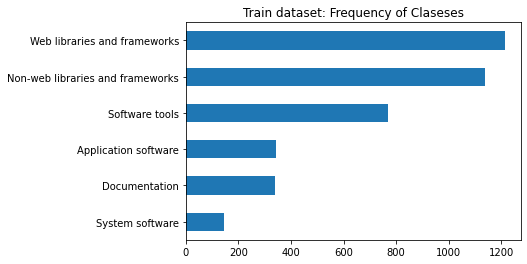

In [9]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Train dataset: Frequency of Claseses')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


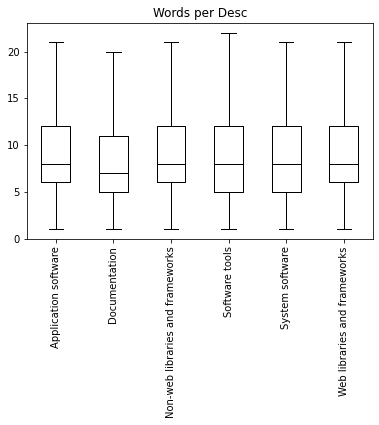

In [50]:
df['Words per Desc'] = df['text'].str.split().apply(len)
df.boxplot('Words per Desc', by='label_name', grid=False, showfliers=False, color='black', rot=90)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [11]:
num_labels = 6
model_ckpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [14]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

In [16]:
ds.reset_format()
ds_encoded = ds.map(tokenize, batched=True, batch_size=None)
print(ds_encoded['train'].column_names)
ds_encoded.set_format('torch', columns=['input_ids', 'attention_mask','label'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask']


In [22]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {'accuraccy': acc, 'f1':f1}


In [23]:
bs = 32 #batch size
epochs = 4
lr = 8e-5
logging_steps = len(ds_encoded['train']) // bs

args = TrainingArguments('outputs', 
                         num_train_epochs=epochs, 
                         learning_rate=lr, 
                         per_device_train_batch_size=bs, 
                         per_device_eval_batch_size=bs,
                         weight_decay=0.01, 
                         evaluation_strategy="epoch",
                         logging_steps=logging_steps)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [24]:
trainer = Trainer(model=model, args=args, compute_metrics=compute_metrics, train_dataset = ds_encoded['train'], eval_dataset = ds_encoded['valid'], tokenizer=tokenizer)
trainer.train();

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3941
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 496


Epoch,Training Loss,Validation Loss,Accuraccy,F1
1,0.362400,1.208059,0.665314,0.652882
2,0.370000,1.184528,0.663286,0.662843
3,0.174200,1.317768,0.665314,0.666969
4,0.083000,1.451124,0.655172,0.652460


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 493
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 493
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 49

In [25]:
pred_output = trainer.predict(ds_encoded['valid'])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 493
  Batch size = 32


In [26]:
pred_output.metrics

{'test_loss': 1.451123595237732,
 'test_accuraccy': 0.6551724137931034,
 'test_f1': 0.652459856244941,
 'test_runtime': 4.4953,
 'test_samples_per_second': 109.67,
 'test_steps_per_second': 3.559}

In [28]:
y_preds = np.argmax(pred_output.predictions, axis =1)

In [46]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False, xticks_rotation='vertical')
  plt.title('Normalized confusion matrix')
  plt.show()

In [47]:
labels = ds['train'].features['label'].names
y_valid = ds['valid']['label']

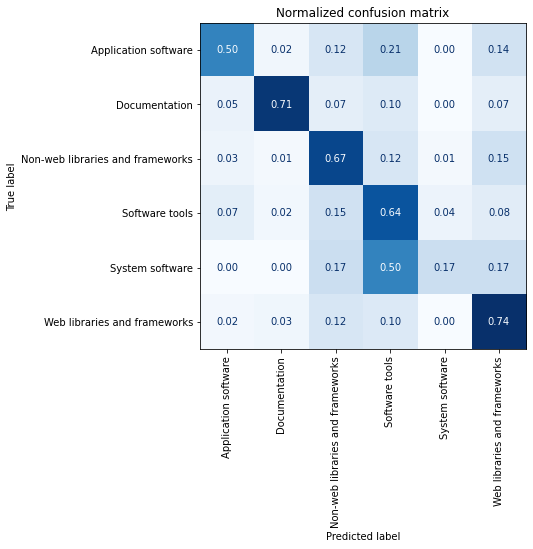

In [48]:
plot_confusion_matrix(y_preds, y_valid, labels)